In [2]:
!pip install tf_keras_vis
# !pip install split-folders
# import splitfolders


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import keras.backend as K
from scipy.ndimage import zoom
from scipy.stats import f_oneway
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import VGG16, InceptionV3, Xception, MobileNetV2, ResNet50
from tensorflow.keras.preprocessing import image
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils import normalize
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.8 MB/s eta 0:00:00


In [ ]:
# import zipfile

# zip_file_path = "/content/drive/MyDrive/Rotation/aptos2019-blindness-detection.zip"

# # Extract the contents of the zip file in the same directory
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(path="/content/drive/MyDrive/Rotation/blind")


In [ ]:
import os
os.listdir("/content/drive/MyDrive/Rotation/blind")

['sample_submission.csv',
 'test.csv',
 'test_images',
 'train.csv',
 'train_images']

In [ ]:
# for system settings

import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import time
# for excessing or creating tabular data
import pandas as pd
import pandas.util.testing as tm
# for matrix manipulation
import numpy as np
# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
# for splitting the data
from sklearn.model_selection import train_test_split

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/Rotation/blind/train.csv")
print("train.csv:")
print("Number of Training images: {}\n".format(train_data.shape[0]))
print(train_data.head(2),"\n")
print("-"*100)
test_data = pd.read_csv("/content/drive/MyDrive/Rotation/blind/test.csv")
print("test.csv: ")
print("Number of Testing images: {}\n".format(test_data.shape[0]))
print(test_data.head(2))
print("\n","-"*100)
print("sample_submission.csv:")
sample_submission = pd.read_csv("/content/drive/MyDrive/Rotation/blind/sample_submission.csv")
print("The format of submitting the final predictions on testing images: ")
print(sample_submission.head(5))

train.csv:
Number of Training images: 3662

        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4 

----------------------------------------------------------------------------------------------------
test.csv: 
Number of Testing images: 1928

        id_code
0  0005cfc8afb6
1  003f0afdcd15

 ----------------------------------------------------------------------------------------------------
sample_submission.csv:
The format of submitting the final predictions on testing images: 
        id_code  diagnosis
0  0005cfc8afb6          0
1  003f0afdcd15          0
2  006efc72b638          0
3  00836aaacf06          0
4  009245722fa4          0


In [5]:
# Intialization of variables which are useful for the later tasks.
img_width = 512
img_height = 512
no_channels = 3
split_size = 0.15
class_labels = {0: 'No DR[0]',1: 'Mild[1]', 2: 'Moderate[2]', 3: 'Severe[3]', 4: 'Proliferative DR[4]'}

Number of Images in train dataset:  3662
Number of Images in test dataset:  1928


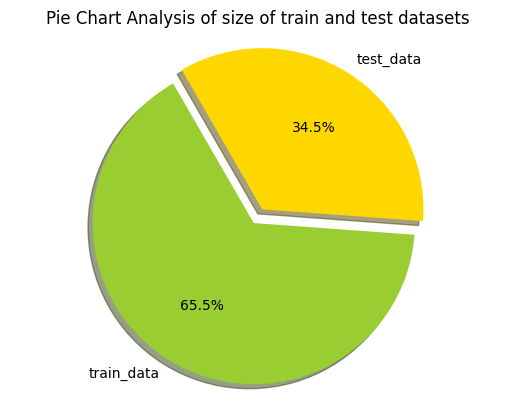

In [ ]:
data = [len(train_data), len(test_data)]
print("Number of Images in train dataset: ", data[0])
print("Number of Images in test dataset: ", data[1])
labels = ['train_data','test_data']
plt.pie(data,explode = [0,0.1], labels= labels, shadow = True, colors = ['yellowgreen','gold'],autopct='%1.1f%%', startangle = 120)
plt.title('Pie Chart Analysis of size of train and test datasets')
plt.axis('equal')
plt.show()

In [ ]:
class_labels_ = list(set(train_data['diagnosis']))
print("Number of target classes: {}".format(class_labels_))

Number of target classes: [0, 1, 2, 3, 4]


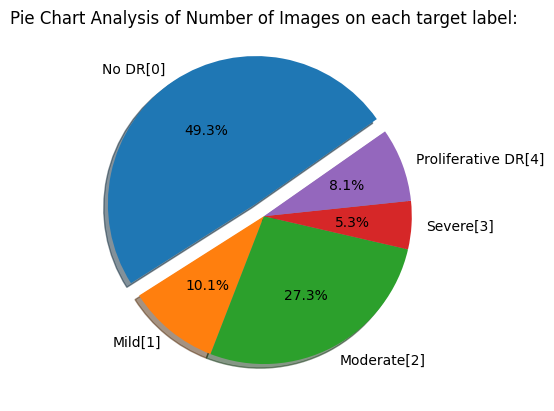

In [ ]:
class_sizes = []
for i in range(0,5):
    class_sizes.append(list(train_data['diagnosis']).count(i))
labels = class_labels.values()
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','darkgreen']
plt.pie(class_sizes,explode = [0.1,0,0,0,0], labels= labels, shadow = True,autopct='%1.1f%%', startangle = 35)
plt.title('Pie Chart Analysis of Number of Images on each target label:')
plt.show()

In [ ]:
train_data

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


In [ ]:
def image_analysis(dataframe, path):
    width_range = []
    height_range = []
    for i in range(dataframe.shape[0]):
        img = cv2.imread(path+dataframe.iloc[i]['id_code']+'.png')
        height, width, _ = img.shape
        width_range.append(width)
        height_range.append(height)
    return width_range, height_range
# Make sure 'train_data' is defined and contains the correct column 'id_code'
width_range, height_range = image_analysis(train_data, '/content/drive/MyDrive/Rotation/blind/train_images/')


In [ ]:
avg_width = sum(width_range)/len(width_range)
avg_height = sum(height_range)/len(height_range)
max_width = max(width_range)
max_height = max(height_range)
min_width = min(width_range)
min_height = min(height_range)
print("Average width of images in training set: {}".format(int(avg_width)))
print("Average height of images in training set: {}".format(int(avg_height)))
print("-"*100)
print("Maximum width of images in training set: {}".format(max_width))
print("Maximum height of images in training set: {}".format(max_height))
print("-"*100)
print("Minimum width of images in training set: {}".format(min_width))
print("Minimum height of images in training set: {}".format(min_height))

Average width of images in training set: 2015
Average height of images in training set: 1526
----------------------------------------------------------------------------------------------------
Maximum width of images in training set: 4288
Maximum height of images in training set: 2848
----------------------------------------------------------------------------------------------------
Minimum width of images in training set: 474
Minimum height of images in training set: 358


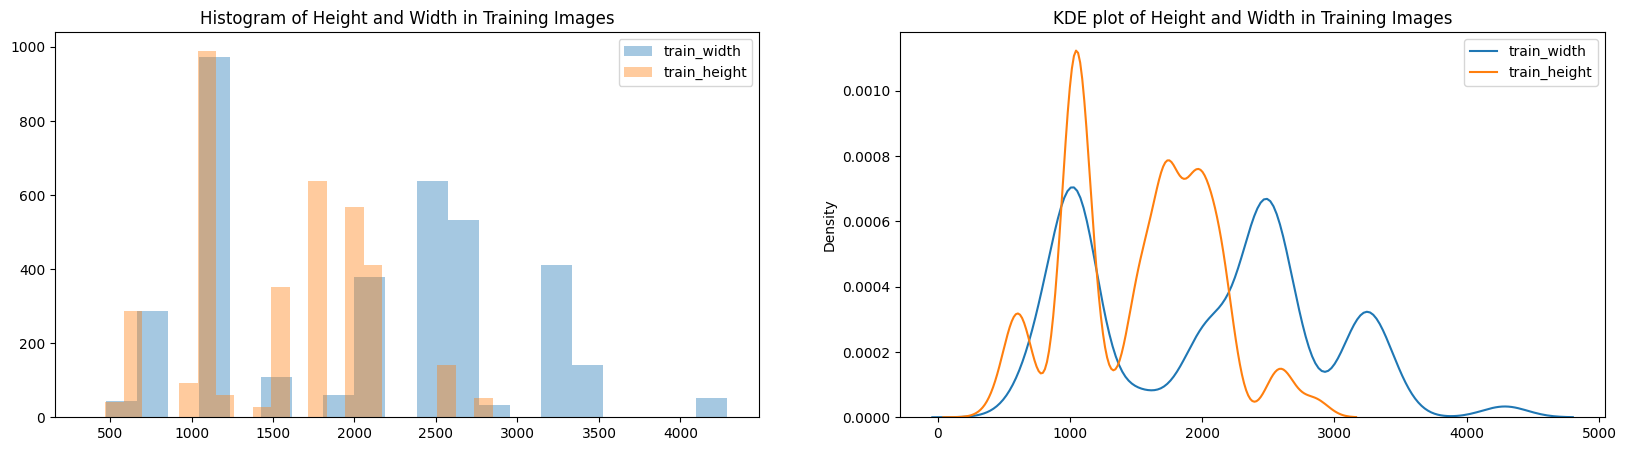

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
sns.distplot(width_range, kde = False, label = 'train_width')
sns.distplot(height_range, kde = False, label = 'train_height')
plt.legend()
plt.title("Histogram of Height and Width in Training Images")
plt.subplot(1,2,2)
sns.kdeplot(width_range, label = 'train_width')
sns.kdeplot(height_range, label = 'train_height')
plt.legend()
plt.title('KDE plot of Height and Width in Training Images')
plt.show()

In [ ]:
width_range_test, height_range_test = image_analysis(test_data, '/content/drive/MyDrive/Rotation/blind/test_images/')
avg_width = sum(width_range_test)/len(width_range_test)
avg_height = sum(height_range_test)/len(height_range_test)
max_width = max(width_range_test)
max_height = max(height_range_test)
min_width = min(width_range_test)
min_height = min(height_range_test)
print("Average width of images in training set: {}".format(int(avg_width)))
print("Average height of images in training set: {}".format(int(avg_height)))
print('-'*100)
print("Maximum width of images in test set: {}".format(max_width))
print("Maximum height of images in test set: {}".format(max_height))
print('-'*100)
print("Minimum width of images in test set: {}".format(min_width))
print("Minimum height of images in test set: {}".format(min_height))

Average width of images in training set: 1043
Average height of images in training set: 783
----------------------------------------------------------------------------------------------------
Maximum width of images in test set: 2896
Maximum height of images in test set: 1958
----------------------------------------------------------------------------------------------------
Minimum width of images in test set: 640
Minimum height of images in test set: 480


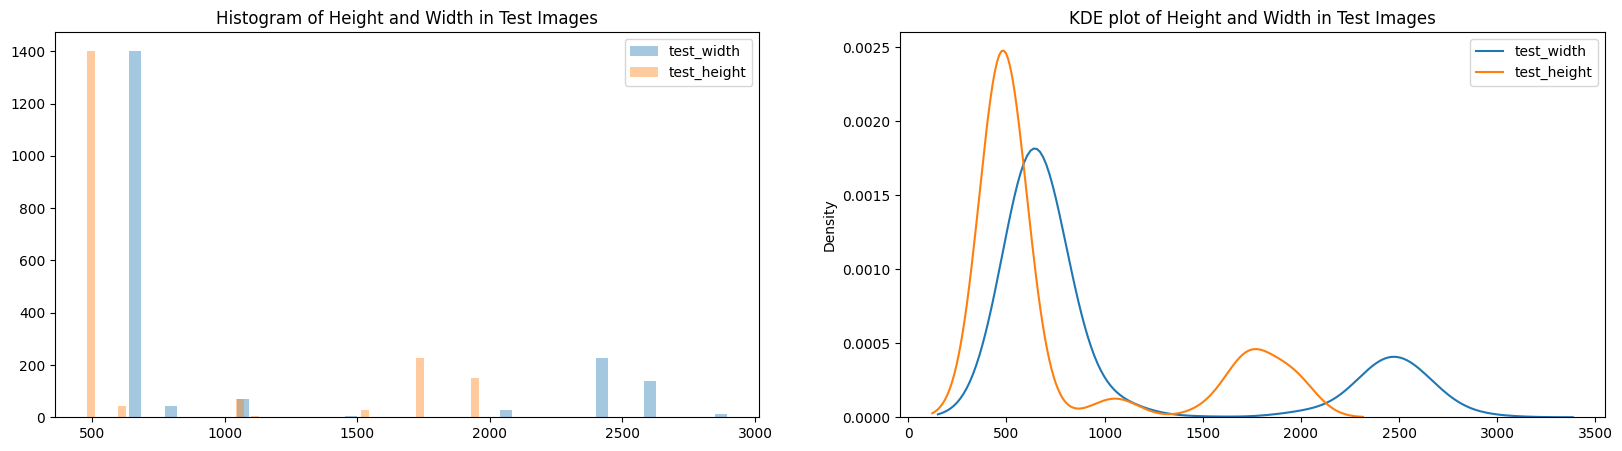

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
sns.distplot(width_range_test, kde = False, label = 'test_width')
sns.distplot(height_range_test, kde = False, label = 'test_height')
plt.legend()
plt.title("Histogram of Height and Width in Test Images")
plt.subplot(1,2,2)
sns.kdeplot(width_range_test, label = 'test_width')
sns.kdeplot(height_range_test, label = 'test_height')
plt.legend()
plt.title('KDE plot of Height and Width in Test Images')
plt.show()

In [ ]:
def splitting_data(train_data, size, is_split = True):
    """
       This function splits the given data into train and validation sets basing on size for validation.
       Args : df - (dataframe) through which splitting is performed
            size - (Integer) test_size -> percentage of data for validation set
            is_split = (boolean) returns train and validation if it is True , otherwise it simply returns the train data
       Outputs : (Series Object) train and validation sets of data

    """
    try:
        if is_split:
            data = train_data['id_code']
            labels = train_data['diagnosis']
            train_x, validation_x, train_labels, validation_labels = train_test_split(data, labels, stratify=labels, shuffle=True, test_size=size)
            print("Training data: {} {}".format(train_x.shape, train_labels.shape))
            print("Validation data: {} {}".format(validation_x.shape,validation_labels.shape))
            return train_x, train_labels, validation_x, validation_labels
        else:
            return train_data['id_code'], train_data['diagnosis'], [], []
    except:
        print("Error: Invalid file format, Function argument requires .csv file!!!")

In [ ]:
train_x, train_labels, validation_x, validation_labels = splitting_data(train_data, split_size)

Training data: (3112,) (3112,)
Validation data: (550,) (550,)


In [ ]:
train = pd.DataFrame(train_x, columns = ['id_code'])
train['diagnosis'] = train_labels
train.to_csv("/content/drive/MyDrive/Rotation/blind/training.csv", index = False)
validation = pd.DataFrame(validation_x, columns = ['id_code'])
validation['diagnosis'] = validation_labels
validation.to_csv('/content/drive/MyDrive/Rotation/blind/validation.csv', index = False)

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Rotation/blind/test.csv')
test.to_csv('/content/drive/MyDrive/Rotation/blind/test.csv', index = False)

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Rotation/blind/training.csv")
validation = pd.read_csv("/content/drive/MyDrive/Rotation/blind/validation.csv")
train_x = train['id_code']
train_labels = train['diagnosis']
validation_x = validation['id_code']
validation_labels = validation['diagnosis']

In [ ]:
def class_analysis(labels, d_set):
    """
    This function plots the histogram of class labels for given set of labels.
    Args : labels - (Series object) which contains the class_labels of train or validation sets.
           d_set - (String) which helps to known whether it is a train or validation set.
    Output : None - this function doesn't return anything
    """
    if d_set == 'training': print("-"*100,'\n')
    counter = labels.value_counts().sort_index()
    counter.plot(kind = 'bar')
    plt.title('Number of images for each Class label in {} set'.format(d_set))
    plt.xlabel('Classes')
    plt.ylabel('Number of images')
    plt.grid()
    plt.show()
    iter=0

    for i in list(set(labels)):
        percentage = list(labels).count(i)/len(list(labels))
        print("Number of images in class - {} ({}) , nearly {} % of total data".format(i,class_labels[i],np.round(percentage*100,4)))
        iter+=1
    if d_set == 'training':
        print("\n","="*100,"\n")
    if d_set == 'validation': print("-"*100,'\n')

---------------------------------------------------------------------------------------------------- 



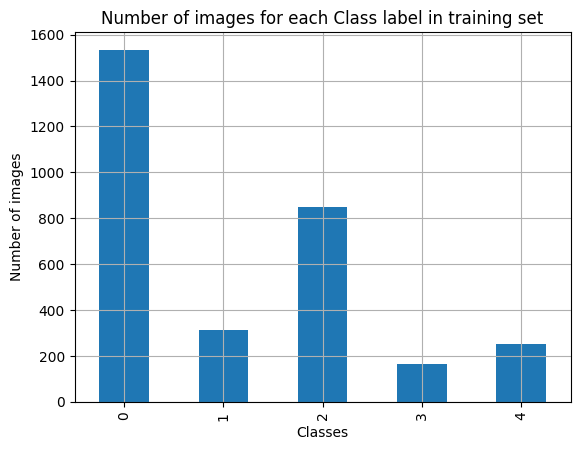

Number of images in class - 0 (No DR[0]) , nearly 49.2931 % of total data
Number of images in class - 1 (Mild[1]) , nearly 10.09 % of total data
Number of images in class - 2 (Moderate[2]) , nearly 27.2815 % of total data
Number of images in class - 3 (Severe[3]) , nearly 5.2699 % of total data
Number of images in class - 4 (Proliferative DR[4]) , nearly 8.0656 % of total data




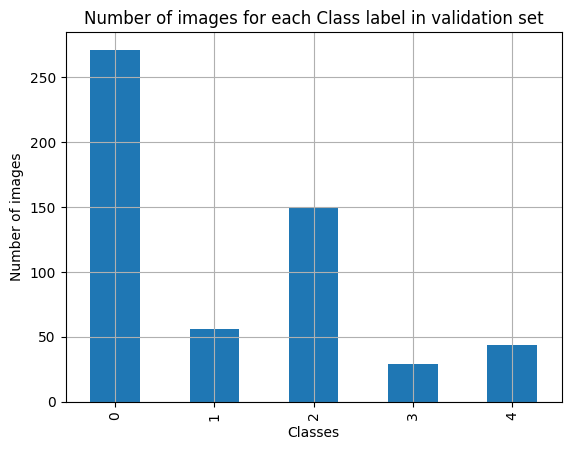

Number of images in class - 0 (No DR[0]) , nearly 49.2727 % of total data
Number of images in class - 1 (Mild[1]) , nearly 10.1818 % of total data
Number of images in class - 2 (Moderate[2]) , nearly 27.2727 % of total data
Number of images in class - 3 (Severe[3]) , nearly 5.2727 % of total data
Number of images in class - 4 (Proliferative DR[4]) , nearly 8.0 % of total data
---------------------------------------------------------------------------------------------------- 



In [ ]:
class_analysis(train_labels,'training')
class_analysis(validation_labels,'validation')

In [3]:
class ImageProcessing:
    def __init__(self, img_height, img_width, no_channels, tol=7, sigmaX=8):

        ''' Initialzation of variables'''

        self.img_height = img_height
        self.img_width = img_width
        self.no_channels = no_channels
        self.tol = tol
        self.sigmaX = sigmaX

    def cropping_2D(self, img, is_cropping = False):

        '''This function is used for Cropping the extra dark part of the GRAY images'''

        mask = img>self.tol
        return img[np.ix_(mask.any(1),mask.any(0))]

    def cropping_3D(self, img, is_cropping = False):

        '''This function is used for Cropping the extra dark part of the RGB images'''

        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>self.tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # if image is too dark we return the image
            return img
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]  #for channel_1 (R)
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]  #for channel_2 (G)
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]  #for channel_3 (B)
            img = np.stack([img1,img2,img3],axis=-1)
        return img

    def Gaussian_blur(self, img, is_gaussianblur = False):

        '''This function is used for adding Gaussian blur (image smoothing technique) which helps in reducing noise in the image.'''

        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0),self.sigmaX),-4,128)
        return img

    def draw_circle(self,img, is_drawcircle = True):

        '''This function is used for drawing a circle from the center of the image.'''

        x = int(self.img_width/2)
        y = int(self.img_height/2)
        r = np.amin((x,y))     # finding radius to draw a circle from the center of the image
        circle_img = np.zeros((img_height, img_width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        return img

    def image_preprocessing(self, img, is_cropping = True, is_gaussianblur = True):

        """
        This function takes an image -> crops the extra dark part, resizes, draw a circle on it, and finally adds a gaussian blur to the images
        Args : image - (numpy.ndarray) an image which we need to process
           cropping - (boolean) whether to perform cropping of extra part(True by Default) or not(False)
           gaussian_blur - (boolean) whether to apply gaussian blur to an image(True by Default) or not(False)
        Output : (numpy.ndarray) preprocessed image
        """

        if img.ndim == 2:
            img = self.cropping_2D(img, is_cropping)  #calling cropping_2D for a GRAY image
        else:
            img = self.cropping_3D(img, is_cropping)  #calling cropping_3D for a RGB image
        img = cv2.resize(img, (self.img_height, self.img_width))  # resizing the image with specified values
        img = self.draw_circle(img)  #calling draw_circle
        img = self.Gaussian_blur(img, is_gaussianblur) #calling Gaussian_blur
        return img

In [ ]:
def images_per_class(class_labels,num, data_x , is_preprocess = False):

    """
    This function plots "num" number of images per each class
    Args : class_labels - (Series Object) which contains the class_labels of train or validation sets.
           num - (Integer) sample number of images to be plot per each class
           data_x - (Series Object) which contains the id_code of each point in train or validation sets.
           is_preprocess - (boolean) whether to perform image processing(True) on image or not(False by Default)
    Output : None - this function doesn't return anything.
    """

    # class_labels num data_x data_y
    labels = list(set(class_labels))
    classes = ['No DR','Mild','Moderate','Severe','Proliferative DR']
    iter=0
    for i in labels:
        j=1
        plt.figure(figsize=(20,5))
        for row in range(len(data_x)):
            if class_labels.iloc[row] == i:
                if is_preprocess == False:plt.subplot(1,num,j)
                else: plt.subplot(1,num*2,j)
                img = cv2.imread('/content/drive/MyDrive/Rotation/blind/train_images/'+data_x.iloc[row]+'.png')
                img1 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                plt.imshow(img1)
                plt.axis('off')
                plt.title("Class = {} ({})".format(class_labels.iloc[row],classes[iter]))
                j+=1
                if is_preprocess == True:
                    obj = ImageProcessing(img_width,img_height,no_channels,sigmaX=14)
                    image = obj.image_preprocessing(img)
                    plt.subplot(1,num*2,j)
                    plt.imshow(image)
                    plt.axis('off')
                    plt.title('==> After Image Processing')
                    j+=1
            if is_preprocess == False and j>num: break
            elif is_preprocess == True and j>num*2: break
        iter+=1
        plt.show()

In [ ]:
images_per_class(train_labels,5,train_x,False)

Output hidden; open in https://colab.research.google.com to view.

In [7]:
def plotting(img, title,i):
    """
    This function is used for subplots
    Args: img (numpy.ndarray) - image we need to plot
          title(string) - title of the plot
          i (integer) -  column number
    output: None - this function doesn't return anything.
    """
    plt.subplot(1,5,i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)

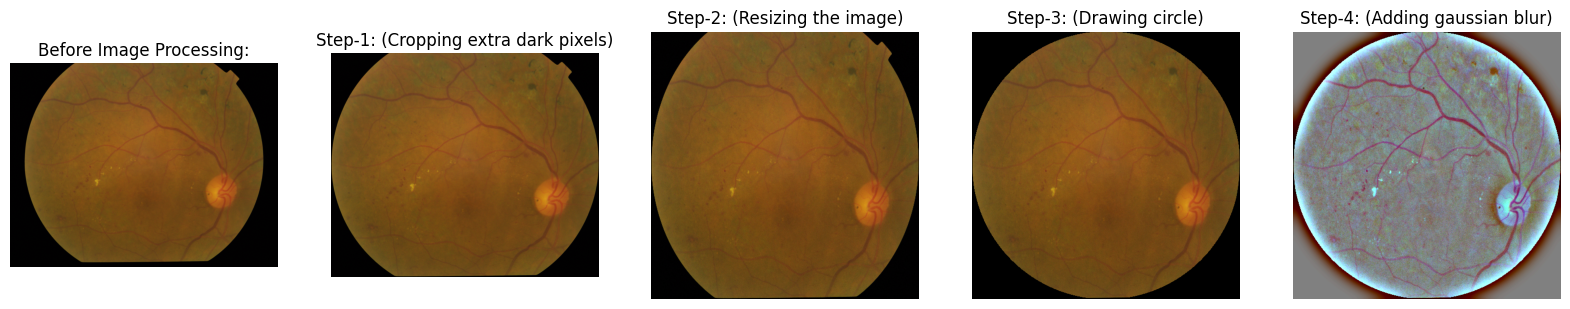

In [9]:
obj1 = ImageProcessing(img_width,img_height, no_channels, sigmaX = 14)
img = '/content/drive/MyDrive/Rotation/blind/train_images/0083ee8054ee.png'  #random train image
img = cv2.imread(img)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,5))
plotting(img1,'Before Image Processing:',1)
img1 = obj1.cropping_3D(img1)
plotting(img1,'Step-1: (Cropping extra dark pixels)',2)
img1 = cv2.resize(img1, (img_height,img_width))
plotting(img1,'Step-2: (Resizing the image)',3)
img1 = obj1.draw_circle(img1)
plotting(img1,'Step-3: (Drawing circle)',4)
img = obj1.image_preprocessing(img,'True')
plotting(img,'Step-4: (Adding gaussian blur)',5)

In [ ]:
images_per_class(train_labels,3,train_x,True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def image_2_vector(data, sep):
    """
    This function is used for Converting an images into a vector and storing it in a file (.npy) format.
    Input: data (Series Object) - which contains the path of the images
           sep (String)   - used in file creation
    Output: None - This function doesn't return anything.
    """
    start_time = time.time()  # storing timestamp
    image_vector = np.empty((len(data),img_width, img_height, no_channels), dtype = np.uint8)
    image_processing = ImageProcessing(img_width, img_height, no_channels, sigmaX)  # Object creation
    if sep !='test':
        c = '/content/drive/MyDrive/Rotation/blind/train_images/'
    else:
        c = '/content/drive/MyDrive/Rotation/blind/test_images/'
    for iter,row in enumerate(tqdm(data)):
        img_path = c+data.iloc[iter]+'.png'
        #img = cv2.imread(path+dataframe.iloc[i]['id_code']+'.png')
        img = cv2.imread(img_path)
        img = image_processing.image_preprocessing(img)    #calling image_preprocessing
        image_vector[iter,:,:,:] = img

    if sep == 'training': print("\nShape of the vector:",image_vector.shape)
    else: print("\n\nShape of the vector:",image_vector.shape)
    print("Time taken to process the {} images: {} seconds".format(sep,np.round(time.time()-start_time,5)))
    path = '/content/drive/MyDrive/Rotation/blind_processed_images'
    print("... Saving image_vector to {}".format(path+'/'+sep))

    if sep == 'training':
        print("\n","-"*100,"\n")
    if not os.path.exists(path):
        os.makedirs(path)
    np.save(path+'/'+sep+'.npy', image_vector)  #saving file

In [ ]:
sigmaX = 14
image_2_vector(train_x, "training") # function calling
image_2_vector(validation_x,"validation")  #function calling

100%|██████████| 3112/3112 [10:21<00:00,  5.01it/s]



Shape of the vector: (3112, 512, 512, 3)
Time taken to process the training images: 621.473 seconds
... Saving image_vector to /content/drive/MyDrive/Rotation/blind_processed_images/training

 ---------------------------------------------------------------------------------------------------- 



100%|██████████| 550/550 [06:34<00:00,  1.40it/s]




Shape of the vector: (550, 512, 512, 3)
Time taken to process the validation images: 394.02118 seconds
... Saving image_vector to /content/drive/MyDrive/Rotation/blind_processed_images/validation


In [ ]:
test = pd.read_csv("/content/drive/MyDrive/Rotation/blind/test.csv")
image_2_vector(test['id_code'], 'test')

100%|██████████| 1928/1928 [25:27<00:00,  1.26it/s]




Shape of the vector: (1928, 512, 512, 3)
Time taken to process the test images: 1527.07167 seconds
... Saving image_vector to /content/drive/MyDrive/Rotation/blind_processed_images/test


In [ ]:
train_x = np.load('/content/drive/MyDrive/Rotation/blind_processed_images/training.npy')  #training set
validation_x = np.load('/content/drive/MyDrive/Rotation/blind_processed_images/validation.npy')  #validation set
test_x = np.load('/content/drive/MyDrive/Rotation/blind_processed_images/test.npy')    #test set

<function matplotlib.pyplot.show(close=None, block=None)>

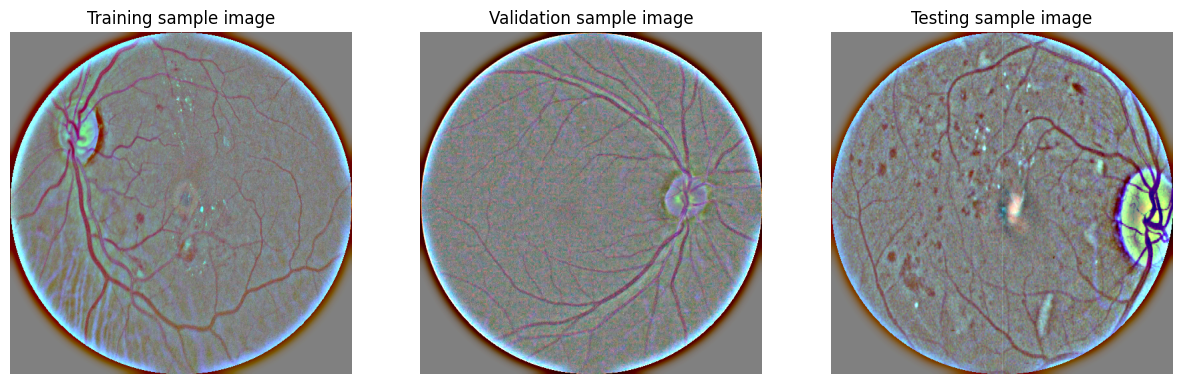

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(train_x[6])   #random training example
plt.axis('off')
plt.title("Training sample image")
plt.subplot(132)
plt.imshow(validation_x[125])    #random validation example
plt.title("Validation sample image")
plt.axis('off')
plt.subplot(133)
plt.imshow(test_x[1206])        #random test example
plt.title("Testing sample image")
plt.axis('off')
plt.show

In [ ]:

# for accessing tabular data
import pandas as pd
import numpy as np
import os
# adding classweight
from sklearn.utils import class_weight
# Evaluation Metric
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# for visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
# backend
import keras
from keras import backend as K
import tensorflow as tf
from keras.callbacks import Callback
from tensorflow.keras.models import Sequential, Model, load_model
# for transfer learning
from keras.applications import VGG16, VGG19
from keras.applications import DenseNet121
from keras.applications import ResNet50, ResNet152
from keras.applications import InceptionV3

from keras.applications import Xception
# for model architecture
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D, MaxPooling2D, Activation, Flatten
# for Tensorboard visualization
from keras.callbacks import TensorBoard
# for Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
try:
    x_train = np.load("/content/drive/MyDrive/Rotation/blind_processed_images/training.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
    x_validation = np.load("/content/drive/MyDrive/Rotation/blind_processed_images/validation.npy",mmap_mode=None, allow_pickle=False, fix_imports=True)
    x_test = np.load("/content/drive/MyDrive/Rotation/blind_processed_images/test.npy", mmap_mode = None,allow_pickle = False, fix_imports = True)
    print("Loaded Successfully...\n")
    print(x_train.shape)
    print(x_validation.shape)
    print(x_test.shape)
except:
    print("file not exists")

Loaded Successfully...

(3112, 512, 512, 3)
(550, 512, 512, 3)
(1928, 512, 512, 3)


In [ ]:
train_labels = pd.read_csv('/content/drive/MyDrive/Rotation/blind/training.csv')
train_labels = train_labels['diagnosis']
validation_labels = pd.read_csv('/content/drive/MyDrive/Rotation/blind/validation.csv')
validation_labels = validation_labels['diagnosis']
print("Training:",train_labels.shape[0])
print("Validation:",validation_labels.shape[0])

Training: 3112
Validation: 550


In [ ]:
def ordinal_regression(labels):
    """
    This function is used to create one_hot_encoding of the labels.
    E.x: category = 3 -> one-hot-encoding [1,1,1,1,0].
         category = 2 -> one-hot-encoding [1,1,1,0,0].
    """
    y_train = pd.get_dummies(labels).values
    y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
    y_train_multi[:, 4] = y_train[:, 4]

    for i in range(3, -1, -1):
         y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])
    return y_train_multi
labels_train = ordinal_regression(train_labels)
labels_validation = ordinal_regression(validation_labels)
print(labels_train[:600].shape)
print(labels_validation.shape)
print("Ex: Original Category: {}\n After one_hot_encoding: {}".format(train_labels.iloc[24],labels_train[24]))

(600, 5)
(550, 5)
Ex: Original Category: 2
 After one_hot_encoding: [1 1 1 0 0]


In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0, 1, 2, 3, 4]),y=train_labels)
print(class_weights)

[0.40573664 1.98216561 0.73309776 3.79512195 2.47968127]


In [ ]:
from scipy.stats import f_oneway
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import VGG16, InceptionV3, Xception, MobileNetV2, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [ ]:
def baseline_model():
    ''' This function is used for building a base line convolutional neural network architecture '''
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(2, 2), input_shape=[512,512,3], activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=128, activation = 'relu'))
    model.add(Dense(units=256, activation = 'relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(5, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      2

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Assuming your labels_train are integer labels for classes
# Compute class weights (this is an important step if your classes are imbalanced)

class_weights_dict = dict(enumerate(class_weights))

# Now, fit the model
history = model.fit(
    x_train,
    labels_train[:600],
    epochs=30,
    batch_size=32,
    verbose=1,
    class_weight=class_weights_dict,  # Use the computed class weights here
    validation_data=(x_validation, labels_validation)
)


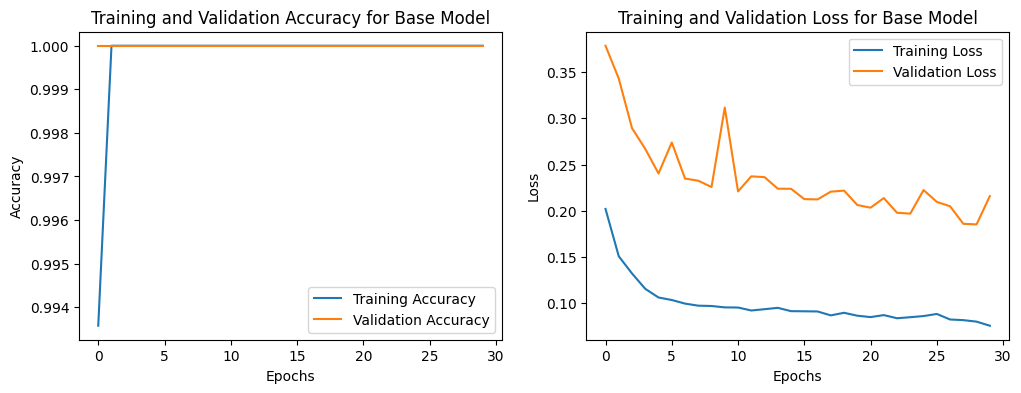

In [ ]:
# Assuming 'history' is the return value from the model.fit call
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # Get number of epochs

# Plot training and validation accuracy per epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Base Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for Base Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Define your CNN model with self-attention
class CNNWithSelfAttention(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(CNNWithSelfAttention, self).__init__()

        self.conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape)
        self.conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.flatten = Flatten()

        self.attention = self_attention(input_shape)  # Self-Attention Layer

        self.fc1 = Dense(64, activation='relu')
        self.fc2 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flatten(x)

        # Apply self-attention
        x = self.attention(x)

        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Define the self-attention mechanism using basic matrix operations
def self_attention(input_shape):
    height, width, input_dim = input_shape  # No batch size in the input_shape tuple

    def inner(x):
        # Reshape to (batch_size, height*width, input_dim)
        reshaped_x = tf.reshape(x, (-1, height * width, input_dim))

        # Compute self-attention scores
        scores = tf.matmul(reshaped_x, reshaped_x, transpose_b=True)
        attention_weights = tf.nn.softmax(scores, axis=-1)

        # Apply attention to the original features
        attended_x = tf.matmul(attention_weights, reshaped_x)

        # Reshape back to original shape
        attended_x = tf.reshape(attended_x, (-1, height, width, input_dim))

        return attended_x

    return inner

# Example usage
input_shape = (512, 512, 3)  # Replace with your input shape
num_classes = 5  # Replace with the number of classes in your dataset

model = CNNWithSelfAttention(input_shape, num_classes)

# Compile the model and specify the optimizer and loss function
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])

# Print a summary of the model's architecture
model.build((None, *input_shape))
model.summary()



Model: "cnn_with_self_attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 conv2d_1 (Conv2D)           multiple                  73856     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  256       
                                                                 
 dense_1 (Dense)             multiple                  325       
                                                                 
Total params: 76229 (297.77 KB)
Trainable params: 76229 (297.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

# Now, fit the model
history = model.fit(
    x_train,
    labels_train[:600],
    epochs=30,
    batch_size=32,
    verbose=1,
    # class_weight=class_weights_dict,  # Use the computed class weights here
    validation_data=(x_validation, labels_validation)
)

In [ ]:
# Assuming 'history' is the return value from the model.fit call
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # Get number of epochs

# Plot training and validation accuracy per epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Base Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for Base Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()